# Running Raven on PAVICS


[Raven](https://raven.uwaterloo.ca) is an hydrological modeling framework that lets hydrologists build hydrological models by combining different hydrological processes together. It can also be used to emulate a variety of existing lumped and distributed models. Model structure, parameters, initial conditions and forcing files are configured in text files, which Raven parses to run hydrological simulations. A detailed description of Raven' modeling capabilities can be found in the [Raven manual](https://www.civil.uwaterloo.ca/raven/files/v3.7/RavenManual_v3.8.pdf)


[RavenPy](https://ravenpy.readthedocs.io) provides a Python interface to Raven, automating the creation of configuration files and allowing the model to be launched from Python. Results, or errors, are automatically parsed and exposed within the programming environment. This facilitates the launch of parallel simulations, multi-model prediction ensembles, sensitivity analyses and other experiments involving a large number of model runs.


## Running Raven from existing configuration files

To run Raven using existing configuration files (`.rv*`), simply call the `ravenpy.run` function with the name of the configuration file and the path to the directory storing the RV files. `run` simply returns the directory storing the model outputs. If Raven emits warnings, those will be printed in the console. If Raven raises errors, `run` will halt the execution with a `RavenError` and display the error messages in `Raven_errors.txt`.

In [1]:
from ravenpy import run

config_dir = "tutorial_data/"
output_dir = "/notebook_dir/writable-workspace/tmp/raven_tutorial_output"
run("raven-gr4j-salmon", configdir=config_dir, outputdir=output_dir)

PosixPath('/notebook_dir/writable-workspace/tmp/raven_tutorial_output')

## Exposing model outputs as Python objects

The model outputs can be read with the `ravenpy.OutputReader`, a class holding the various Raven outputs as attributes. Streamflow time series and model state variables are exposed as `xarray.Dataset` objects within the  `hydrograph` and `storage` attributes respectively.

Note that an `EnsembleReader` class is also available to merge together outputs from multiple simulations.  

<xarray.Dataset> Size: 33kB
Dimensions:                    (time: 209)
Coordinates:
  * time                       (time) datetime64[ns] 2kB 1954-01-01 ... 1954-...
Data variables: (12/19)
    rainfall                   (time) float64 2kB ...
    snowfall                   (time) float64 2kB ...
    channel_storage            (time) float64 2kB ...
    reservoir_storage          (time) float64 2kB ...
    rivulet_storage            (time) float64 2kB ...
    Surface Water              (time) float64 2kB ...
    ...                         ...
    Convolution Storage[0]     (time) float64 2kB ...
    Convolution Storage[1]     (time) float64 2kB ...
    total                      (time) float64 2kB ...
    cum_input                  (time) float64 2kB ...
    cum_outflow                (time) float64 2kB ...
    MB_error                   (time) float64 2kB ...
Attributes:
    Conventions:  CF-1.6
    featureType:  timeSeries
    history:      Created by Raven
    description:  Standard Output

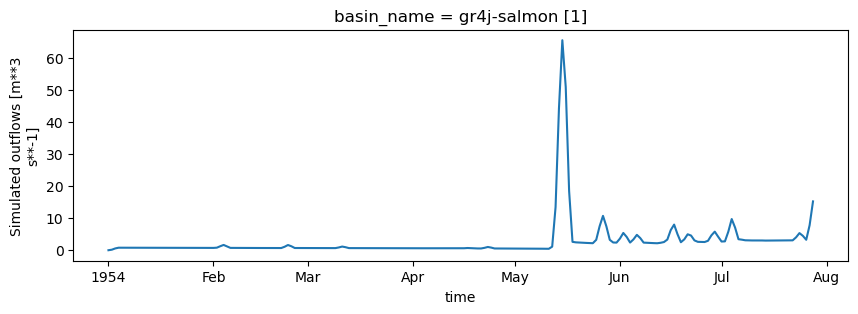

In [2]:
from ravenpy import OutputReader

out = OutputReader(path=output_dir)
display(out.storage)
out.hydrograph.q_sim.plot(figsize=(10, 3))

## Configuring model emulators

Ravenpy comes packaged with pre-configured emulators, that is, Raven model configurations that can be modified on the fly. For example, the code below creates a model configuration for emulated model GR4JCN using parameter values (`params`), various simulation options, well as a `Gauge` command whose content is inferred from inspecting the netCDF file storing meteorological inputs.

Note that the method `Gauge.from_nc` below is able to parse the meteorological input file because its variable are named according to the [CF Convention](https://cfconventions.org/). Variables names can be given explicitly if that's not the case.  

In [3]:
import datetime as dt

from ravenpy.config.commands import Gauge
from ravenpy.config.emulators import GR4JCN

meteo = config_dir + "Salmon-River-Near-Prince-George_meteo_daily.nc"
gr4jcn = GR4JCN(
    params=[0.5, -3.0, 400, 1.0, 17, 0.9],
    StartDate=dt.datetime(2000, 1, 1),
    EndDate=dt.datetime(2002, 1, 1),
    Gauge=[
        Gauge.from_nc(meteo, data_type=["RAINFALL", "TEMP_MIN", "TEMP_MAX", "SNOWFALL"])
    ],
    GlobalParameter={"AVG_ANNUAL_RUNOFF": 208.480},
    HRUs=[
        dict(
            area=4250.6,
            elevation=843.0,
            latitude=54.4848,
            longitude=-123.3659,
            hru_type="land",
        )
    ],
)

The RV files for the emulator above can be inspected using the `rvi`, `rvh`, `rvp`, `rvc` and `rvt` properties, e.g. `print(gr4jcn.rvt)` will show the `rvt` file as it would be written to disk. Configuration files can then be written to disk using `gr4jcn.write_rv(workdir, modelname)`, and the model launched using the `run` function introduced before.

In [4]:
print(gr4jcn.rvi)

:Calendar             PROLEPTIC_GREGORIAN
:StartDate            2000-01-01 00:00:00
:EndDate              2002-01-01 00:00:00
:TimeStep             1.0
:Routing              ROUTE_NONE
:CatchmentRoute       ROUTE_DUMP
:Evaporation          PET_OUDIN
:RainSnowFraction     RAINSNOW_DINGMAN
:OroTempCorrect       OROCORR_SIMPLELAPSE
:OroPrecipCorrect     OROCORR_SIMPLELAPSE
:SoilModel            SOIL_MULTILAYER 4
:HydrologicProcesses
  :Precipitation        PRECIP_RAVEN        ATMOS_PRECIP        MULTIPLE
  :SnowTempEvolve       SNOTEMP_NEWTONS     SNOW_TEMP
  :SnowBalance          SNOBAL_CEMA_NIEGE   SNOW                PONDED_WATER
  :OpenWaterEvaporation OPEN_WATER_EVAP     PONDED_WATER        ATMOSPHERE
  :Infiltration         INF_GR4J            PONDED_WATER        MULTIPLE
  :SoilEvaporation      SOILEVAP_GR4J       SOIL[0]             ATMOSPHERE
  :Percolation          PERC_GR4J           SOIL[0]             SOIL[2]
  :Flush                RAVEN_DEFAULT       SURFACE_WATER       SOI

For convenience, `ravenpy` also proposes the `Emulator` class, designed to streamline the execution of the model and the retrieval of the results. It accepts a model configuration object as an input, then can launch a simulation with the `run` method, which returns an `OutputReader` instance. 

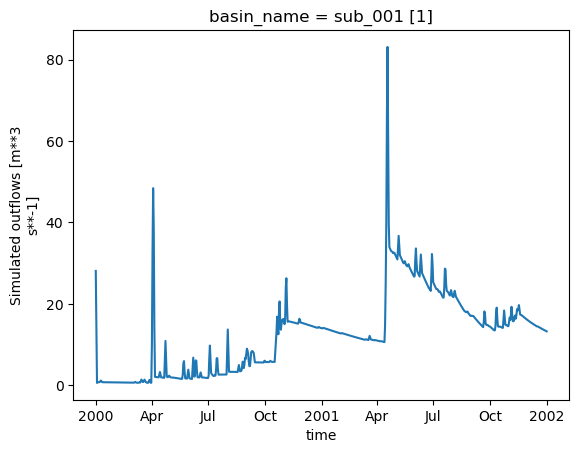

In [5]:
from ravenpy import Emulator

e = Emulator(config=gr4jcn)
out = e.run()
out.hydrograph.q_sim.plot()